# Introduction to JumpStart - Text to Image

***
Welcome to Amazon [SageMaker JumpStart](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-jumpstart.html)! You can use JumpStart to solve many Machine Learning tasks through one-click in SageMaker Studio, or through [SageMaker JumpStart API](https://sagemaker.readthedocs.io/en/stable/overview.html#use-prebuilt-models-with-sagemaker-jumpstart).  In this demo notebook, we demonstrate how to use the JumpStart API to generate images from text using state-of-the-art Stable Diffusion models. Furthermore, we show how to fine-tune the model to your dataset.

Stable Diffusion is a text-to-image model that enables you to create photorealistic images from just a text prompt. A diffusion model trains by learning to remove noise that was added to a real image. This de-noising process generates a realistic image. These models can also generate images from text alone by conditioning the generation process on the text. For instance, Stable Diffusion is a latent diffusion where the model learns to recognize shapes in a pure noise image and gradually brings these shapes into focus if the shapes match the words in the input text.

Training and deploying large models and running inference on models such as Stable Diffusion is often challenging and include issues such as cuda out of memory, payload size limit exceeded and so on.  JumpStart simplifies this process by providing ready-to-use scripts that have been robustly tested. Furthermore, it provides guidance on each step of the process including the recommended instance types, how to select parameters to guide image generation process, prompt engineering etc. Moreover, you can deploy and run inference on any of the 80+ Diffusion models from JumpStart without having to write any piece of your own code.

In this notebook, you will learn how to use JumpStart to generate highly realistic and artistic images of any subject/object/environment/scene. This may be as simple as an image of a cute dog or as detailed as a hyper-realistic image of a beautifully decoraded cozy kitchen by pixer in the style of greg rutkowski with dramatic sunset lighting and long shadows with cinematic atmosphere. This can be used to design products and build catalogs for ecommerce business needs or to generate realistic art pieces or stock images.


Model lincese: By using this model, you agree to the [CreativeML Open RAIL-M++ license](https://huggingface.co/stabilityai/stable-diffusion-2/blob/main/LICENSE-MODEL).

***

1. [Set Up](#1.-Set-Up)
2. [Run inference on the pre-trained model](#2.-Run-inference-on-the-pre-trained-model)
    * [Select a model](#2.1.-Select-a-Model)
    * [Retrieve JumpStart Artifacts & Deploy an Endpoint](#2.2.-Retrieve-JumpStart-Artifacts-&-Deploy-an-Endpoint)
    * [Query endpoint and parse response](#2.3.-Query-endpoint-and-parse-response)
    * [Supported Inference parameters](#2.4.-Supported-Inference-parameters)
    * [Compressed Image Output](#2.5.-Compressed-Image-Output)
    * [Prompt Engineering](#2.6.-Prompt-Engineering)
    * [Clean up the endpoint](#2.7.-Clean-up-the-endpoint)
3. [Conclusion](#3.-Conclusion)


Note: This notebook was tested on ml.t3.medium instance in Amazon SageMaker Studio with Python 3 (Data Science) kernel and in Amazon SageMaker Notebook instance with conda_python3 kernel.

Note: To deploy the pre-trained model, you can use `ml.p3.2xlarge` or `ml.g4dn.2xlarge` instance types. If `ml.g5.2xlarge` is available in your region, we recommend using that instance type for deployment. 

### 1. Set Up

***
Before executing the notebook, there are some initial steps required for set up. This notebook requires latest version of sagemaker and ipywidgets

***

In [3]:
!pip install ipywidgets==7.0.0 --quiet


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


#### Permissions and environment variables

***
To host on Amazon SageMaker, we need to set up and authenticate the use of AWS services. Here, we use the execution role associated with the current notebook as the AWS account role with SageMaker access.

***

In [4]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 2. Run inference on the pre-trained model

***

Using JumpStart, we can perform inference on the pre-trained model, even without fine-tuning it first on a new dataset.
***

### 2.1. Select a Model
***
You can continue with the default model, or can choose a different model from the dropdown generated upon running the next cell. A complete list of SageMaker pre-trained models can also be accessed at [Sagemaker pre-trained Models](https://sagemaker.readthedocs.io/en/stable/doc_utils/pretrainedmodels.html#).

***

In [5]:
from ipywidgets import Dropdown
from sagemaker.jumpstart.notebook_utils import list_jumpstart_models

# Retrieves all Text-to-Image generation models.
filter_value = "task == txt2img"
txt2img_models = list_jumpstart_models(filter=filter_value)

# display the model-ids in a dropdown to select a model for inference.
model_dropdown = Dropdown(
    options=txt2img_models,
    value="model-txt2img-stabilityai-stable-diffusion-v2-1-base",
    description="Select a model",
    style={"description_width": "initial"},
    layout={"width": "max-content"},
)
display(model_dropdown)

A Jupyter Widget

In [6]:
# model_version="*" fetches the latest version of the model
model_id, model_version = model_dropdown.value, "*"

### 2.2. Retrieve JumpStart Artifacts & Deploy an Endpoint

***

Using JumpStart, we can perform inference on the pre-trained model, even without fine-tuning it first on a new dataset. We start by retrieving the `deploy_image_uri`, `deploy_source_uri`, and `model_uri` for the pre-trained model. To host the pre-trained model, we create an instance of [sagemaker.model.Model](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html) and deploy it.

### This may take upto 10 minutes. Please do not kill the kernel while you wait.

While you wait, you can checkout the [Generate images from text with the stable diffusion model on Amazon SageMaker JumpStart](https://aws.amazon.com/blogs/machine-learning/generate-images-from-text-with-the-stable-diffusion-model-on-amazon-sagemaker-jumpstart/) blog to learn more about Stable Diffusion model and JumpStart.


***

In [7]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base


endpoint_name = name_from_base(f"jumpstart-example-infer-{model_id}")

# Please use ml.g5.24xlarge instance type if it is available in your region. ml.g5.24xlarge has 24GB GPU compared to 16GB in ml.p3.2xlarge and supports generation of larger and better quality images.
inference_instance_type = "ml.p3.2xlarge"

# Retrieve the inference docker container uri. This is the base HuggingFace container image for the default model above.
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)

# Retrieve the inference script uri. This includes all dependencies and scripts for model loading, inference handling etc.
deploy_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope="inference"
)


# Retrieve the model uri. This includes the pre-trained nvidia-ssd model and parameters.
model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope="inference"
)

# To increase the maximum response size from the endpoint.
env = {
    "MMS_MAX_RESPONSE_SIZE": "20000000",
}

# Create the SageMaker model instance
model = Model(
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    model_data=model_uri,
    entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
    role=aws_role,
    predictor_cls=Predictor,
    name=endpoint_name,
    env=env,
)

# deploy the Model. Note that we need to pass Predictor class when we deploy model through Model class,
# for being able to run inference through the sagemaker API.
model_predictor = model.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    predictor_cls=Predictor,
    endpoint_name=endpoint_name,
)

---------!

### 2.3. Query endpoint and parse response

***
Input to the endpoint is any string of text dumped in json and encoded in `utf-8` format. Output of the endpoint is a `json` with generated text.

***

In [8]:
import matplotlib.pyplot as plt
import numpy as np


def query(model_predictor, text):
    """Query the model predictor."""

    encoded_text = text.encode("utf-8")

    query_response = model_predictor.predict(
        encoded_text,
        {
            "ContentType": "application/x-text",
            "Accept": "application/json",
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return generated image and the prompt"""

    response_dict = json.loads(query_response)
    return response_dict["generated_image"], response_dict["prompt"]


def display_img_and_prompt(img, prmpt):
    """Display hallucinated image."""
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()

***
Below, we put in some example input text. You can put in any text and the model predicts the image corresponding to that text.

***

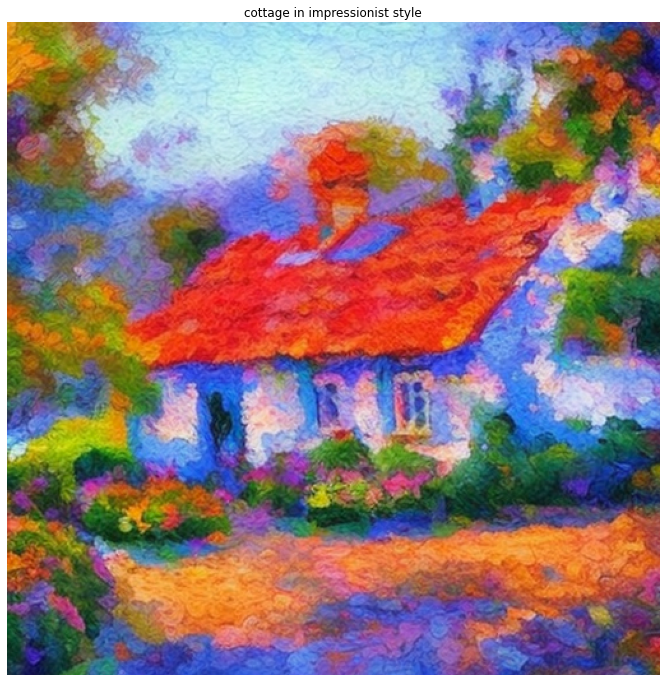

In [9]:
text = "cottage in impressionist style"
query_response = query(model_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

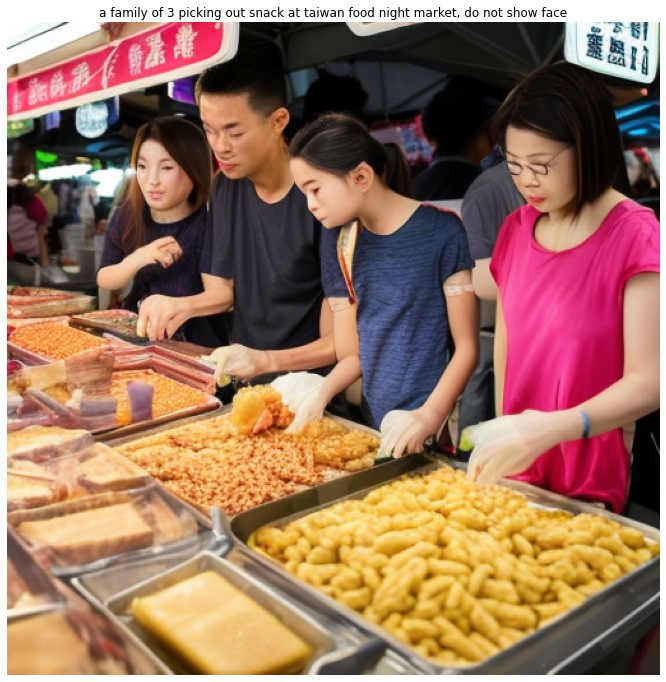

In [12]:
text = "a cat watching a "
query_response = query(model_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

### 2.4. Supported Inference parameters

***
This model also supports many advanced parameters while performing inference. They include:

* **prompt**: prompt to guide the image generation. Must be specified and can be a string or a list of strings.
* **width**: width of the hallucinated image. If specified, it must be a positive integer divisible by 8.
* **height**: height of the hallucinated image. If specified, it must be a positive integer divisible by 8.
* **num_inference_steps**: Number of denoising steps during image generation. More steps lead to higher quality image. If specified, it must a positive integer.
* **guidance_scale**: Higher guidance scale results in image closely related to the prompt, at the expense of image quality. If specified, it must be a float. guidance_scale<=1 is ignored.
* **negative_prompt**: guide image generation against this prompt. If specified, it must be a string or a list of strings and used with guidance_scale. If guidance_scale is disabled, this is also disabled. Moreover, if prompt is a list of strings then negative_prompt must also be a list of strings. 
* **num_images_per_prompt**: number of images returned per prompt. If specified it must be a positive integer. 
* **seed**: Fix the randomized state for reproducibility. If specified, it must be an integer.

***

In [ ]:
import json

# Training data for different models had different image sizes and it is often observed that the model performs best when the generated image
# has dimensions same as the training data dimension. For dimensions not matching the default dimensions, it may result in a black image.
# Stable Diffusion v1-4 was trained on 512x512 images and Stable Diffusion v2 was trained on 768x768 images.
payload = {
    "prompt": "astronaut on a horse",
    "width": 512,
    "height": 512,
    "num_images_per_prompt": 1,
    "num_inference_steps": 50,
    "guidance_scale": 7.5,
}


def query_endpoint_with_json_payload(model_predictor, payload, content_type, accept):
    """Query the model predictor with json payload."""

    encoded_payload = json.dumps(payload).encode("utf-8")

    query_response = model_predictor.predict(
        encoded_payload,
        {
            "ContentType": content_type,
            "Accept": accept,
        },
    )
    return query_response


def parse_response_multiple_images(query_response):
    """Parse response and return generated image and the prompt"""

    response_dict = json.loads(query_response)
    return response_dict["generated_images"], response_dict["prompt"]


query_response = query_endpoint_with_json_payload(
    model_predictor, payload, "application/json", "application/json"
)
generated_images, prompt = parse_response_multiple_images(query_response)

for img in generated_images:
    display_img_and_prompt(img, prompt)

### 2.5. Compressed Image Output

---

Default response type above from an endpoint is a nested array with RGB values and if the generated image size is large, this may hit response size limit. To address this, we also support endpoint response where each image is returned as a JPEG image returned as bytes. To do this, please set `Accept = 'application/json;jpeg'`.


---

In [ ]:
from PIL import Image
from io import BytesIO
import base64
import json

query_response = query_endpoint_with_json_payload(
    model_predictor, payload, "application/json", "application/json;jpeg"
)
generated_images, prompt = parse_response_multiple_images(query_response)

# generated_images are a list of jpeg images as bytes with b64 encoding.


def display_encoded_images(generated_images, prompt):
    # we decode the images and convert to RGB format before displaying
    for generated_image in generated_images:
        generated_image_decoded = BytesIO(base64.b64decode(generated_image.encode()))
        generated_image_rgb = Image.open(generated_image_decoded).convert("RGB")
        display_img_and_prompt(generated_image_rgb, prompt)


display_encoded_images(generated_images, prompt)

### 2.6. Prompt Engineering
---
Writing a good prompt can sometime be an art. It is often difficult to predict whether a certain prompt will yield a satisfactory image with a given model. However, there are certain templates that have been observed to work. Broadly, a prompt can be roughly broken down into three pieces: (i) type of image (photograph/sketch/painting etc.), (ii) description (subject/object/environment/scene etc.) and (iii) the style of the image (realistic/artistic/type of art etc.). You can change each of the three parts individually to generate variations of an image. Adjectives have been known to play a significant role in the image generation process. Also, adding more details help in the generation process.

To generate a realistic image, you can use phrases such as “a photo of”, “a photograph of”, “realistic” or “hyper realistic”. To generate images by artists you can use phrases like “by Pablo   Piccaso” or “oil painting by Rembrandt” or “landscape art by Frederic Edwin Church” or “pencil drawing by Albrecht Dürer”. You can also combine different artists as well. To generate artistic image by category, you can add the art category in the prompt such as “lion on a beach, abstract”. Some other categories include “oil painting”, “pencil drawing, “pop art”, “digital art”, “anime”, “cartoon”, “futurism”, “watercolor”, “manga” etc. You can also include details such as lighting or camera lens such as 35mm wide lens or 85mm wide lens and details about the framing (portrait/landscape/close up etc.).

Note that model generates different images even if same prompt is given multiple times. So, you can generate multiple images and select the image that suits your application best.

---

In [ ]:
prompts = [
    "a beautiful illustration of a young cybertronic hyderabadi american woman, round face, cateye glasses, purple colors, intricate, sharp focus, illustration, highly detailed, digital painting, concept art, matte, art by wlop and artgerm and greg rutkowski and alphonse mucha, masterpiece",
    "a photorealistic hyperrealistic render of an interior of a beautifully decorated cozy kitchen by pixar, greg rutkowski, wlop, artgerm, dramatic moody sunset lighting, long shadows, volumetric, cinematic atmosphere, octane render, artstation, 8 k",
    "symmetry!! portrait of nicolas cage, long hair in the wind, smile, happy, white vest, intricate, elegant, highly detailed, digital painting, artstation, concept art, smooth, sharp focus, illustration, art by artgerm and greg rutkowski and alphonse mucha",
    "a stunningly detailed stained glass window of a beautiful poison ivy with green skin wearing a business suit, dark eyeliner, intricate, elegant, highly detailed, digital painting, artstation, concept art, sharp focus, illustration, art by greg rutkowski and alphonse mucha",
    "a fantasy style portrait painting of rachel lane / alison brie / sally kellerman hybrid in the style of francois boucher oil painting unreal 5 daz. rpg portrait, extremely detailed artgerm greg rutkowski alphonse mucha",
    "symmetry!! portrait of vanessa hudgens in the style of horizon zero dawn, machine face, intricate, elegant, highly detailed, digital painting, artstation, concept art, smooth, sharp focus, illustration, art by artgerm and greg rutkowski and alphonse mucha, 8 k",
    "landscape of the beautiful city of paris rebuilt near the pacific ocean in sunny california, amazing weather, sandy beach, palm trees, splendid haussmann architecture, digital painting, highly detailed, intricate, without duplication, art by craig mullins, greg rutkwowski, concept art, matte painting, trending on artstation",
]
for prompt in prompts:
    payload = {"prompt": prompt, "width": 512, "height": 512}
    query_response = query_endpoint_with_json_payload(
        model_predictor, payload, "application/json", "application/json;jpeg"
    )
    generated_images, prompt = parse_response_multiple_images(query_response)
    display_encoded_images(generated_images, "generated image with detailed prompt")

### 2.7. Clean up the endpoint

In [ ]:
# Delete the SageMaker endpoint
model_predictor.delete_model()
model_predictor.delete_endpoint()

### 3. Conclusion
---
In this tutorial, we learnt how to deploy a pre-trained Stable Diffusion model on SageMaker using JumpStart. We saw that Stable Diffusion models can generate highly photo-realistic images from text.  JumpStart provides both Stable Diffusion 1 and Stable Diffusion 2 and their FP16 revisions. JumpStart also provides additional 84 diffusion models which have been trained to generate images from different themes and different languages. You can deploy any of these models without writing any code of your own.  To deploy a specific model, you can select a `model_id` in the dropdown menu in [2.1. Select a Model](#2.1.-Select-a-Model).

You can tweak the image generation process by selecting the appropriate parameters during inference. Guidance on how to set these parameters is provided in [2.4. Supported Inference parameters](#2.4.-Supported-Inference-parameters). We also saw how returning a large image payload can lead to response size limit issues. JumpStart handles it by encoding the image at the endpoint and decoding it in the notebook before displaying. Finally, we saw how prompt engineering is a crucial step in generating high quality images. We discussed how to set your own prompts and saw a some examples of good prompts.

To learn more about Inference on pre-trained Stable Diffusion models, please check out the blog [Generate images from text with the stable diffusion model on Amazon SageMaker JumpStart](https://aws.amazon.com/blogs/machine-learning/generate-images-from-text-with-the-stable-diffusion-model-on-amazon-sagemaker-jumpstart/)

